In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from pmdarima.arima import auto_arima
import warnings

## ARIMA

In [4]:
file_path = "data/EMECS_Raw_Data.xlsx"
countries = ['Canada', 'China', 'France', 'Germany', 'India', 'Italy', 'Japan', 'Russia', 'United Kingdom', 'United States']

NO_TRASFORMATION = 'No Transformation'
DIFFERENCING = 'Differencing'
LOG_TRANSFORMATION = 'Log Transformation'

TYPE_NON_STATIONARY = "non_stationary"
TYPE_STATIONARY = "stationary"

# feature selection
NO_SELECTION = 'no_selection'
MUTUAL_INFO = 'mutual_info'
CORRELATION = 'correlation'
fs_methods = [NO_SELECTION, MUTUAL_INFO, CORRELATION]

In [5]:
raw_df = pd.read_excel(file_path, sheet_name="sheet1")
df = raw_df
df['year'] = pd.to_datetime(df['year'], format='%Y')
df.index = df['year']

In [6]:
ts_last_train_year = 2021
ts_predict_year = 2022
ts_train_df = df[(df.index <= pd.to_datetime(ts_last_train_year, format='%Y'))]
ts_test_df = df[(df.index == pd.to_datetime(ts_predict_year, format='%Y'))]

In [ ]:
ts_train_df

In [ ]:
ts_train_df

## Reference:
### [Source 1. ARIMA step by step](https://www.justintodata.com/arima-models-in-python-time-series-prediction/) <br>
### [Source 2. ARIMA step by step](https://www.analyticsvidhya.com/blog/2020/10/how-to-create-an-arima-model-for-time-series-forecasting-in-python/)

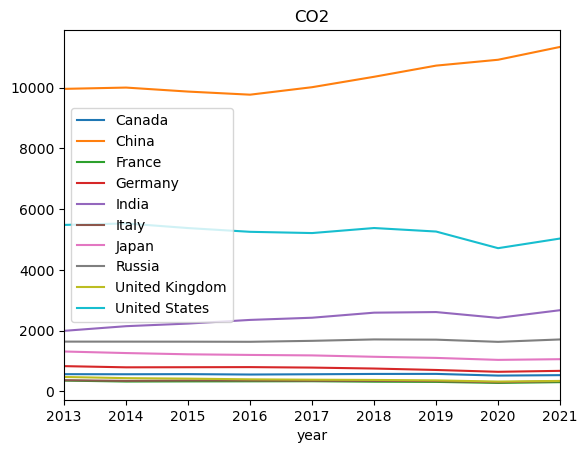

In [7]:
for country in countries:
  country_co2 = ts_train_df[(ts_train_df['country'] == country)]['co2']
  country_co2.plot(title='CO2')
  plt.legend(countries)

# Check if CO2 can be transformed to stationary data

In [8]:
# Step 1: Check for stationarity of time series
# From the plot we assume the data is non-stationary.
# Use ADF test:
# H0: The null hypothesis: It is a statement about the population that either is believed to be true or is used to put forth an argument unless it can be shown to be incorrect beyond a reasonable doubt.
# H1: The alternative hypothesis: It is a claim about the population that is contradictory to H0 and what we conclude when we reject H0.

stationary_dict = {}
transform_methods = [NO_TRASFORMATION, DIFFERENCING, LOG_TRANSFORMATION]
p_result = []

for country in countries:
  for method in transform_methods:
    country_co2 = ts_train_df[(ts_train_df['country'] == country)]['co2']
    if method == DIFFERENCING:
      country_co2 = country_co2.diff().dropna()
    elif method == LOG_TRANSFORMATION:
      country_co2 = np.log(country_co2)
    adf_test = adfuller(country_co2)
    if adf_test[1] > 0.05: # non-stationary
      p_result.append({'country': country, 'p_value': adf_test[1], 'transform_method': method, 'is_stationary': False})
    if adf_test[1] <= 0.05: # stationary
      p_result.append({'country': country, 'p_value': adf_test[1], 'transform_method': method, 'is_stationary': True})
      stationary_dict[country] = {method: country_co2}
      break
non_stationary = list(set(countries) - set(stationary_dict.keys()))

In [9]:
p_result_df = pd.DataFrame.from_dict(p_result)
p_result_df

,country,p_value,transform_method,is_stationary
0,Canada,2.266944e-14,No Transformation,True
1,China,9.952632e-01,No Transformation,False
2,China,7.953160e-01,Differencing,False
3,China,9.948014e-01,Log Transformation,False
4,France,3.131987e-01,No Transformation,False
5,France,3.777112e-01,Differencing,False
6,France,3.444151e-01,Log Transformation,False
7,Germany,9.136550e-01,No Transformation,False
8,Germany,3.365378e-01,Differencing,False
9,Germany,9.114736e-01,Log Transformation,False


In [10]:
print(f'stationary: {list(stationary_dict.keys())}\nnon_stationary: {non_stationary}') # CO2 in these countries cannot be transformed to stationary

stationary: ['Canada', 'Italy', 'Japan', 'Russia']
non_stationary: ['Germany', 'India', 'United States', 'China', 'United Kingdom', 'France']


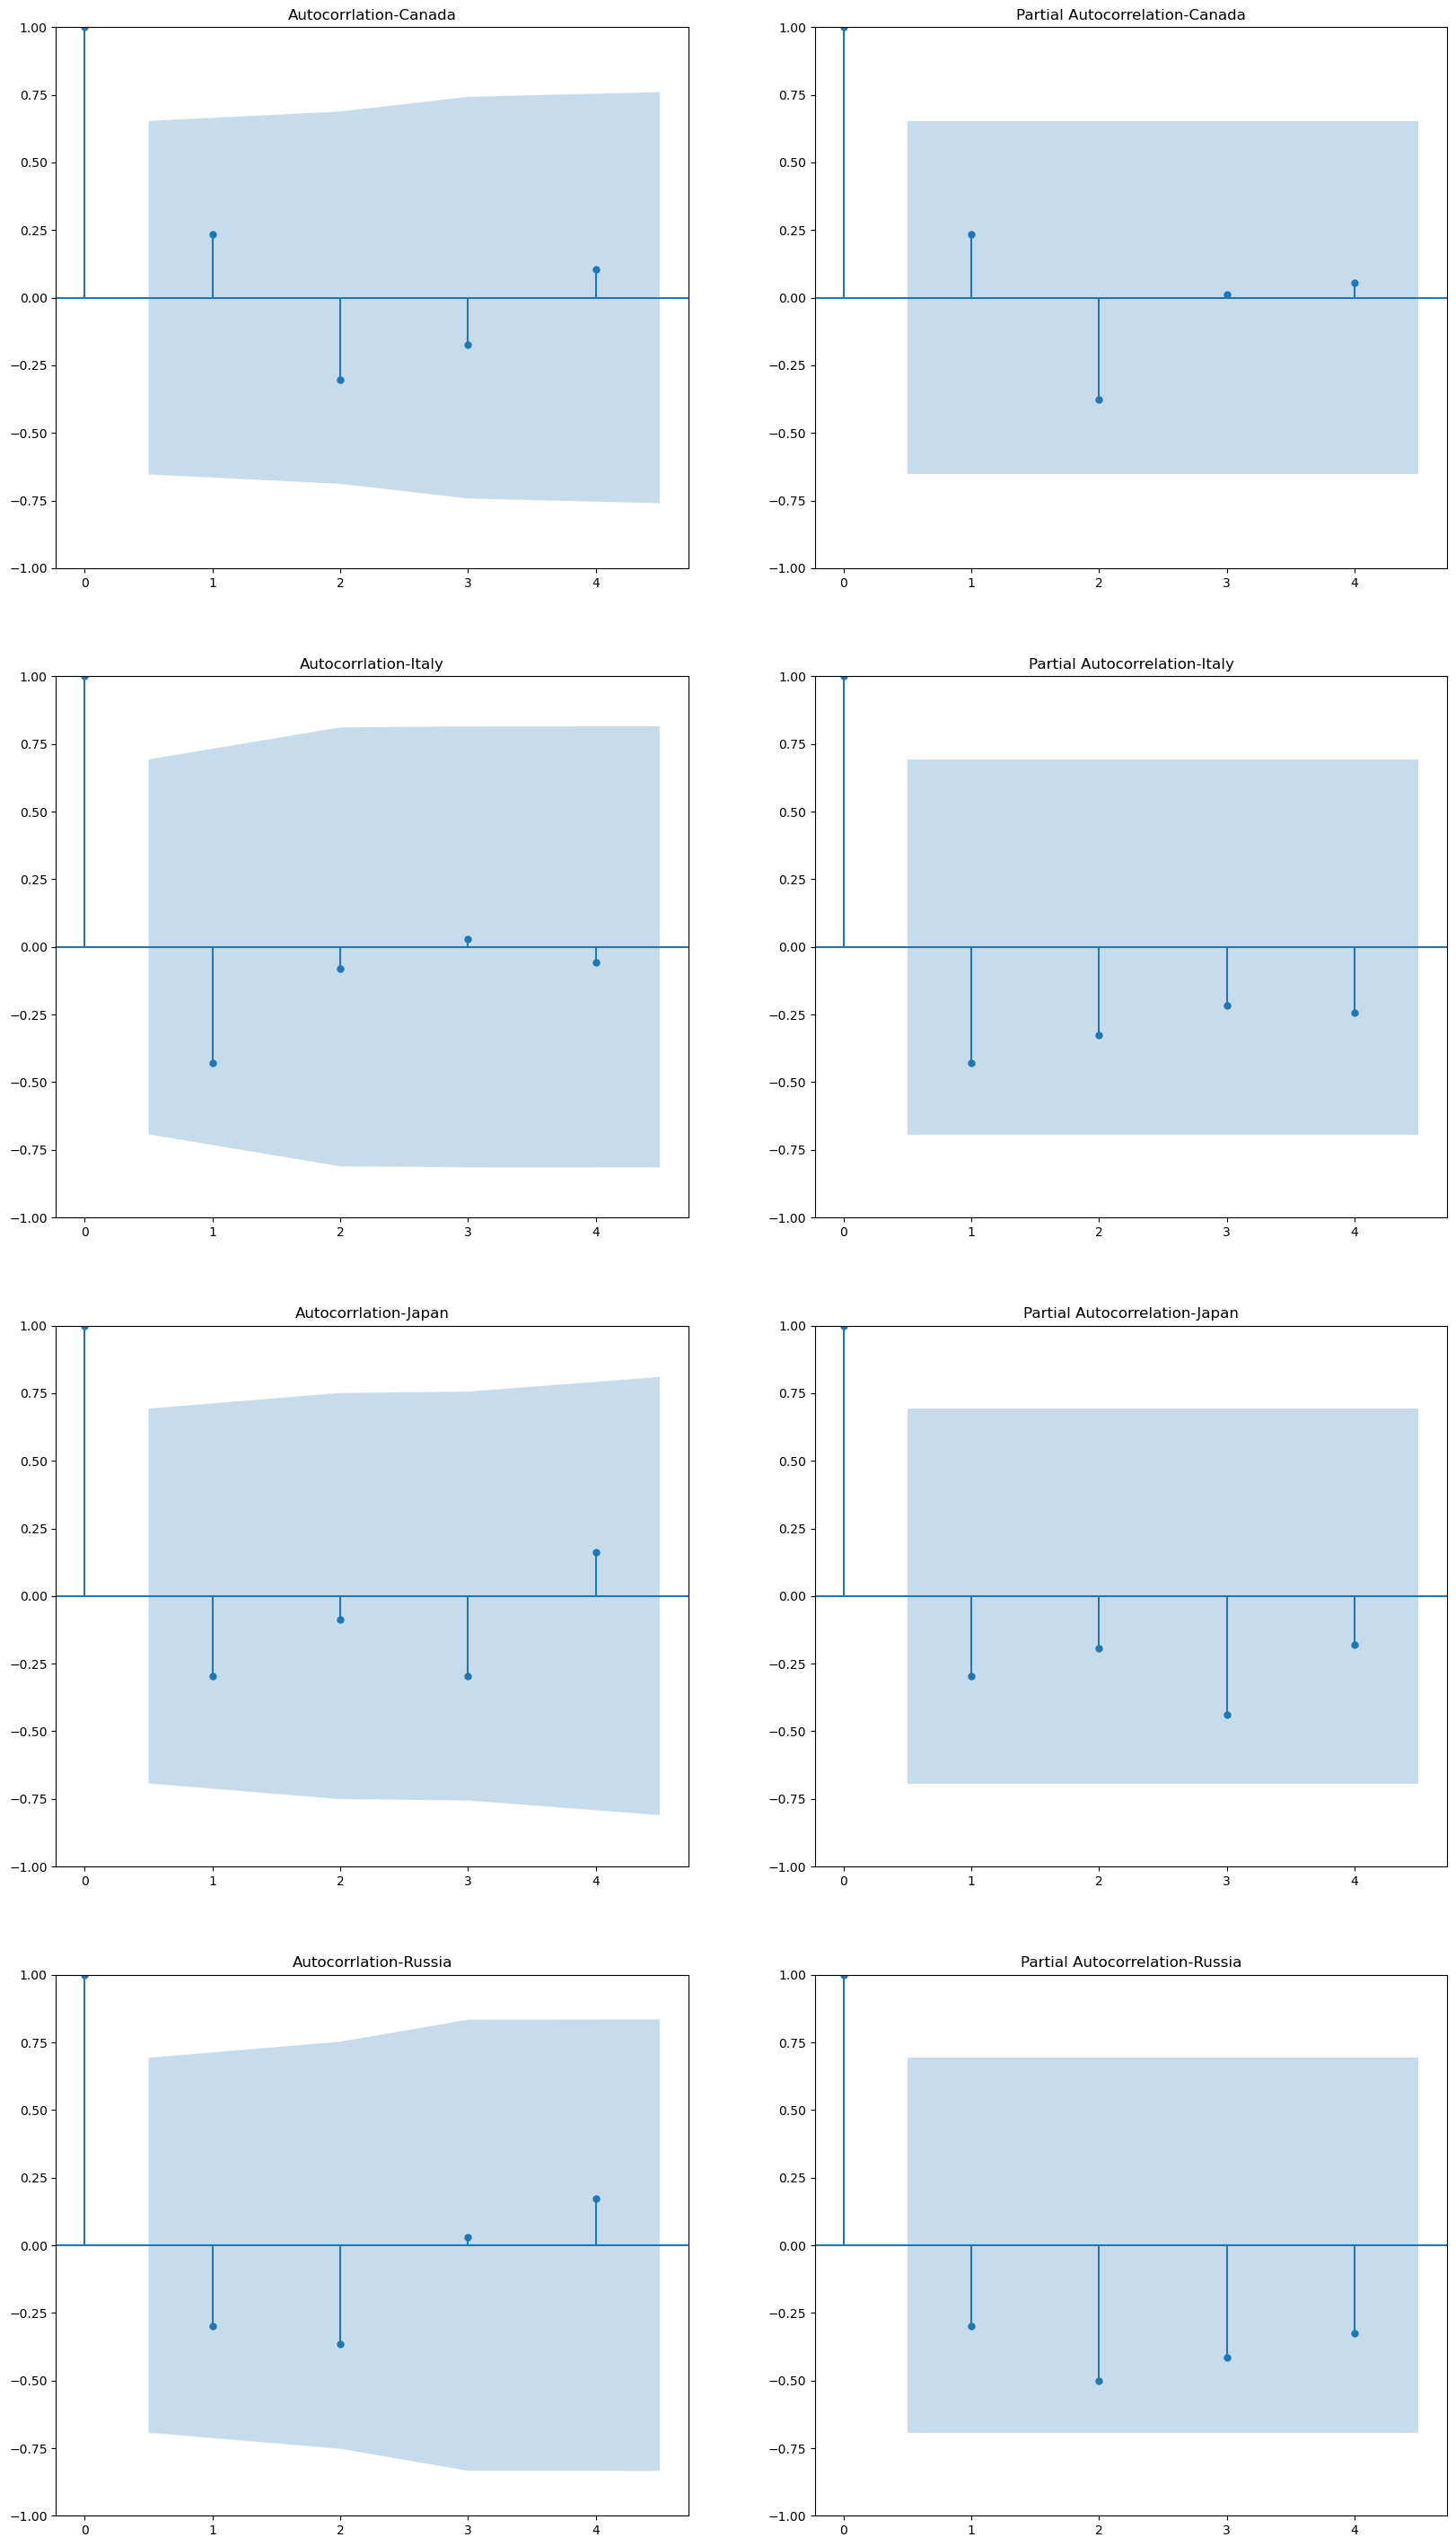

In [11]:
# draw graphs for stationary data
fig, axes = plt.subplots(len(stationary_dict), 2, figsize=(20, 36))
# lag = 3
i = 0
for country in countries:
  if not stationary_dict.get(country):
    continue
  for method, transformed_data in stationary_dict[country].items():
    acf_diff = plot_acf(transformed_data, ax =axes[i][0], title=f"Autocorrlation-{country}")
    pacf_diff = plot_pacf(transformed_data, ax=axes[i][1], title=f"Partial Autocorrelation-{country}")
    i += 1

In [12]:
def add_result_row(country, model_name, aic, param_order, param_seasonal_order, trans_method, actual_forecast, predicted_forecast, mse, error_percentage, features=None, fs_method=None):
  return {'Country': country, 
          'Model': model_name, 
          'MSE': mse, 
          'Error Percentage': error_percentage,
          'Feature Selection': fs_method,
          'Features': features,
          'Type': 'Countrywise',
          'AIC': aic, 
          'Order': param_order, 
          'Seasonal Order': param_seasonal_order, 
          'Transformation': trans_method, 
          f'Forecast Year ({ts_predict_year}) Actual': actual_forecast, 
          f'Forecast Year ({ts_predict_year}) Predicted': predicted_forecast,
          }

def calculate_error_percentage(actual_forecast, predicted):
  return (abs(actual_forecast - predicted)/ actual_forecast) * 100

def calculate_mse(actual, predicted):
  return mean_squared_error([actual], [predicted])

# Select features countrywise - Correlation & Mutual Info

In [13]:
features_cols = ts_train_df.columns.drop(['year', 'country', 'iso_code', 'code_year', 'co2']).to_list()
features_cols


NO_SELECTION = 'no_selection'

In [14]:
features_dict = {country: {fs_m: features_cols if fs_m == NO_SELECTION else None for fs_m in fs_methods} for country in countries}

In [15]:
# Method 1:Correlation

def get_high_correlated_features(ts_train_df):
  # Step1: check which features are high correlated with co2
  corr_columns = features_cols + ['co2']
  cor = ts_train_df[corr_columns].corr()
  cor_target = abs(cor["co2"])
  relevant_features = cor_target[cor_target > 0.5]
  # print(f"relevant-to-co2 features:\n{relevant_features.index}") # These features are highly correlated with co2 value

  # Step2: check if remaining features have high correlated tendency with each other
  related_to_co2_features = relevant_features.index.drop('co2')
  relevant_features_arr = ts_train_df[related_to_co2_features].to_numpy()
  correlation_matrix = np.corrcoef(relevant_features_arr, rowvar=False)
  corr_matrix_df = pd.DataFrame(correlation_matrix, columns=related_to_co2_features, index=related_to_co2_features)
  corr_matrix_df = corr_matrix_df[corr_matrix_df <= 0.95] # These features are suitable for training
  selected_features = corr_matrix_df.index
  # print(f"correlation matrix:\n{selected_features}")
  return selected_features.tolist()

for country in countries:
  country_df = ts_train_df[(ts_train_df['country'] == country)]
  features_dict[country][CORRELATION] = get_high_correlated_features(country_df)

In [16]:
# Method 2:Mutual Info
def select_k_best_mutual_info(train_df, test_df):
  X_train = train_df[features_cols]
  # X_test = test_df[features_cols]
  y_train = train_df['co2']
  y_test = test_df['co2']

  # First: not choosting any feature

  # Evaluate the performance of the model with different number of features
  mses = []

  for k in range(1, len(features_cols)+1):
    fs = SelectKBest(score_func=mutual_info_regression, k=k).fit(X_train, y_train)
    selected_features = fs.get_feature_names_out(features_cols)
    
    X_train_selected = train_df[selected_features]
    X_test_selected = test_df[selected_features]

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    mses.append(calculate_mse(y_test, y_pred))

  # Determine the optimal number of features
  optimal_k = mses.index(min(mses)) + 1
  # print("mses: ", mses)
  # print(f"Optimal number of features: {optimal_k}")
  return optimal_k

def get_features_by_mutual_info(train_df, test_df) -> list:
  k_value = select_k_best_mutual_info(train_df, test_df)
  X_train = train_df[features_cols]
  y_train = train_df['co2']
  # print("k_value: ", k_value)
  fs = SelectKBest(score_func=mutual_info_regression, k=k_value).fit(X_train, y_train)
  return fs.get_feature_names_out(features_cols).tolist()

mutual_features_dict = {}
for country in countries:
  country_train_df = ts_train_df[(ts_train_df['country'] == country)]
  country_test_df = ts_test_df[(ts_test_df['country'] == country)]
  features_dict[country][MUTUAL_INFO] = get_high_correlated_features(country_df)

In [17]:
features_dict

{'Canada': {'no_selection': ['population',
   'gdp',
   'coal_co2',
   'flaring_co2',
   'gas_co2',
   'methane',
   'oil_co2',
   'electricity_generation_twh'],
  'mutual_info': ['population', 'gdp', 'coal_co2', 'gas_co2', 'oil_co2'],
  'correlation': ['population',
   'coal_co2',
   'oil_co2',
   'electricity_generation_twh']},
 'China': {'no_selection': ['population',
   'gdp',
   'coal_co2',
   'flaring_co2',
   'gas_co2',
   'methane',
   'oil_co2',
   'electricity_generation_twh'],
  'mutual_info': ['population', 'gdp', 'coal_co2', 'gas_co2', 'oil_co2'],
  'correlation': ['population',
   'coal_co2',
   'flaring_co2',
   'gas_co2',
   'methane',
   'oil_co2',
   'electricity_generation_twh']},
 'France': {'no_selection': ['population',
   'gdp',
   'coal_co2',
   'flaring_co2',
   'gas_co2',
   'methane',
   'oil_co2',
   'electricity_generation_twh'],
  'mutual_info': ['population', 'gdp', 'coal_co2', 'gas_co2', 'oil_co2'],
  'correlation': ['population',
   'gdp',
   'coal_co2'

In [18]:
def tuning_SARIMA_parameter(train_series, actual_forecast):
  p = d = q = range(0, 2)
  param_seasonal_os = [(p, d, q, 12) for p, d, q in itertools.product(range(0, 5), repeat=3)]
  best_order, best_seasonal_o, best_mse, best_aic = None, None, float('inf'), float('inf')
  for order in itertools.product(p, d, q):
    for s_order in param_seasonal_os:
      model = SARIMAX(train_series, order=order, seasonal_order=s_order, freq='AS-JAN', enforce_stationarity=False)
      model_fit = model.fit(disp=0)
      predicted_results = model_fit.forecast(steps=1)
      predicted_forecast_value = predicted_results.iloc[0]
      mse = np.mean((actual_forecast - predicted_forecast_value)**2)
      if mse < best_mse:
          best_mse = mse
          best_aic = model_fit.aic
          best_order, best_seasonal_o = order, s_order
          best_predicted_forecast = predicted_forecast_value

  return best_order, best_seasonal_o, best_aic, best_predicted_forecast

def tuning_SARIMA_parameter_exog(train_series, train_exog, test_exog, actual_forecast):
    p = d = q = range(0, 2)
    param_seasonal_os = [(p, d, q, 12) for p, d, q in itertools.product(range(0, 5), repeat=3)]
    best_order, best_seasonal_o, best_mse, best_aic = None, None, float('inf'), float('inf')
    for order in itertools.product(p, d, q):
        for s_order in param_seasonal_os:
            model = SARIMAX(train_series, exog=train_exog, order=order, trend='n',seasonal_order=s_order, freq='AS-JAN', enforce_stationarity=False)
            model_fit = model.fit(disp=0)
            predicted_results = model_fit.forecast(steps=1,exog=test_exog)
            predicted_forecast_value = predicted_results.iloc[0]
            mse = np.mean((actual_forecast - predicted_forecast_value)**2)
            if mse < best_mse:
                best_mse = mse
                best_aic = model_fit.aic
                best_order, best_seasonal_o = order, s_order
                best_predicted_forecast = predicted_forecast_value

    return best_order, best_seasonal_o, best_aic, best_predicted_forecast

# ARIMA - stationary countries <br> SARIMA - non-stationary countries
## with or without exogenous parameters

In [19]:
# stationary -> ARIMA fit it in corresponding method
stationary_result = []

for country, obj in stationary_dict.items():
  actual_forecast = ts_test_df[(ts_test_df['country'] == country)]['co2'].iloc[0]
  for method, series in obj.items():
    stepwise_fit = auto_arima(series, seasonal=True, m=1, suppress_warnings=True)
    param_o = stepwise_fit.get_params()['order']
    model = ARIMA(series, order=param_o, freq='AS-JAN')
    model_fit = model.fit()
    forecast_values = model_fit.forecast(steps=1)

    if method == DIFFERENCING:
      forecast_values = np.cumsum(forecast_values) + ts_train_df[(ts_train_df['country'] == country)]['co2'].iloc[-1]
    elif method == LOG_TRANSFORMATION:
      forecast_values = np.exp(forecast_values)

    predicted_forecast = forecast_values.iloc[0]
    
    # calculate squared residual for this country
    mse = calculate_mse(actual_forecast, predicted_forecast)
    err_percent = calculate_error_percentage(actual_forecast, predicted_forecast)
  stationary_result.append(add_result_row(country, 'ARIMA', model_fit.aic, param_o, None, method, actual_forecast, predicted_forecast, mse, err_percent, 'No Features', 'No Features'))

/opt/miniconda3/envs/co2-predict/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/co2-predict/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/co2-predict/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/co2-predict/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/co2-predict/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' wa

In [ ]:
# non-stationary after transformation, train it using SARIMA
warnings.filterwarnings("ignore")
non_stationary_result = []
for country in non_stationary:
  actual_forecast = ts_test_df[(ts_test_df['country'] == country)]['co2'].iloc[0]
  country_co2 = ts_train_df[(ts_train_df['country'] == country)]['co2']
  param_o, param_seasonal_o, aic, predicted_forecast = tuning_SARIMA_parameter(ts_train_df[(ts_train_df['country'] == country)]['co2'], actual_forecast)
  if param_o == None:
    print(f"{country} has no optimal params")
    continue

  # calculate squared residual for this country
  mse = calculate_mse(actual_forecast, predicted_forecast)
  err_percent = calculate_error_percentage(actual_forecast, predicted_forecast)

  non_stationary_result.append(add_result_row(country, 'SARIMA', model_fit.aic, param_o, param_seasonal_o,  None, actual_forecast, predicted_forecast, mse, err_percent, 'No Features', 'No Features'))

In [ ]:
X_train = ts_train_df.drop(columns=['year', 'code_year', 'iso_code','co2'])
y_train = ts_train_df[['country','co2']]
X_test = ts_test_df.drop(columns=['year', 'code_year', 'iso_code','co2'])
y_test = ts_test_df[['country','co2']]

In [ ]:
for i in features_dict:
  print(i)

In [ ]:
arima_ex_result = []

for country, fs_methods in features_dict.items():
  for fs_method, features in fs_methods.items():
    actual_forecast = y_test[(y_test['country'] == country)]['co2'].iloc[0]
    X_train_country = X_train[(X_train['country'] == country)][features]
    y_train_country = y_train[(y_train['country'] == country)]['co2']
    X_test_country = X_test[(X_test['country'] == country)][features]
    stepwise_fit = auto_arima(y=y_train_country, X=X_train_country, seasonal=True, m=1, suppress_warnings=True)
    param_o = stepwise_fit.get_params()['order']
    model = ARIMA(endog=y_train_country, exog=X_train_country, order=param_o, trend='n',freq='AS-JAN')
    model_fit = model.fit()
    forecast_values = model_fit.forecast(steps=1,exog=X_test_country)
    predicted_forecast = forecast_values.iloc[0]
    # calculate squared residual for this country
    mse = calculate_mse(actual_forecast, predicted_forecast)
    features_txt = "\n".join(features)
    if len(features) == 8:
      features_txt = 'all'
    err_percent = calculate_error_percentage(actual_forecast, predicted_forecast)
    arima_ex_result.append(add_result_row(country=country, 
                                          model_name='ARIMA with exog', 
                                          aic=model_fit.aic, 
                                          param_order=param_o, 
                                          param_seasonal_order=None, 
                                          trans_method = None, 
                                          actual_forecast=actual_forecast, 
                                          predicted_forecast=predicted_forecast, 
                                          mse=mse, 
                                          error_percentage=err_percent,
                                          features=features_txt,
                                          fs_method=fs_method
                                          ))


In [ ]:
sarima_ex_result = []

for country, fs_methods in features_dict.items():
  for fs_method, features in fs_methods.items():
    actual_forecast = y_test[(y_test['country'] == country)]['co2'].iloc[0]
    y_train_country = y_train[(y_train['country'] == country)]['co2']
    X_train_country = X_train[(X_train['country'] == country)][features]
    X_test_country = X_test[(X_test['country'] == country)][features]
    param_o, param_seasonal_o, aic, predicted_forecast = tuning_SARIMA_parameter_exog(train_series= y_train_country, 
                                                                                      train_exog=X_train_country,
                                                                                      test_exog=X_test_country,
                                                                                      actual_forecast=actual_forecast)
    # calculate squared residual for this country
    mse = calculate_mse(actual_forecast, predicted_forecast)
    err_percent = calculate_error_percentage(actual_forecast, predicted_forecast)
    features_txt = "\n".join(features)
    if len(features) == 8:
      features_txt = 'all'
    sarima_ex_result.append(add_result_row(country=country, 
                                          model_name='SARIMA with exog', 
                                          aic=aic, 
                                          param_order=param_o, 
                                          param_seasonal_order=param_seasonal_o, 
                                          trans_method = None, 
                                          actual_forecast=actual_forecast, 
                                          predicted_forecast=predicted_forecast, 
                                          mse=mse, 
                                          error_percentage=err_percent,
                                          features=features_txt,
                                          fs_method=fs_method)
    )


In [ ]:
all_result_df = pd.DataFrame.from_dict(stationary_result + non_stationary_result + arima_ex_result + sarima_ex_result)
all_result_df.to_csv('result_ts.csv', index=False)